# The One Goal For Today

To understand different types of distance function used in k-means clustering and in other modeling methods.

# Distances

We've talked quite a bit so far about distances
* Distances to calculate the error for fitting a regression
* Distances in high dimensional space for PCA

Basically, the distance you define is up to you. It could be:
* Euclidean distance
* Manhattan distance
* Chebyshev distance
* Minkowski distance
* Hamming distance
... and the list goes on!

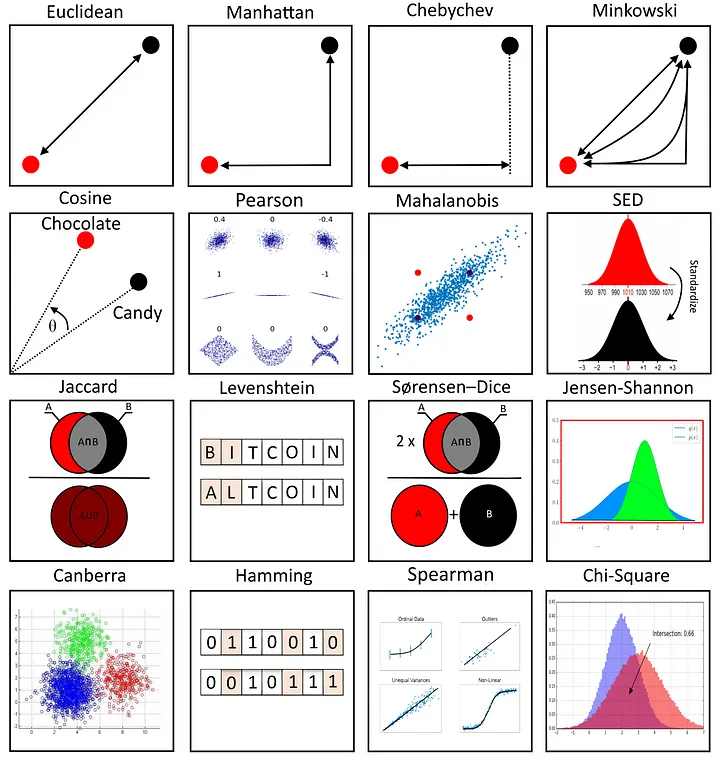

*Image source: https://towardsdatascience.com/17-types-of-similarity-and-dissimilarity-measures-used-in-data-science-3eb914d2681*

## Rules for distance functions

The rules for defining a distance function $d$ are:
* $d$ must assign a scalar value that indicates how "far apart" two vectors $\vec{a}$ and $\vec{b}$ are
* $d(\vec{a}, \vec{b}) \geq 0$ for any $\vec{a}, \vec{b}$
* $d(\vec{a}, \vec{a}) = 0$
* The triangular inequality must be obeyed: $d(\vec{a}, \vec{c}) \leq d(\vec{a}, \vec{b}) + d(\vec{b}, \vec{c})$
* It must be commutative (invariant to argument order): $d(\vec{a}, \vec{b}) = d(\vec{b}, \vec{a})$

*Why do you think these are important?*

## Euclidean distance

Euclidean distance is defined as:
$$d(\vec{a}, \vec{b}) = \sqrt{\sum_{i=1}^m (a_i - b_i)^2}$$

We write this as $||\vec{a} - \vec{b}||_2$.

We call this the *L2 norm*. The neighborhood to a point can be drawn as a circle.

In [ ]:
# in code here:
def distance(a, b):
    pass

## Manhattan distance

Manhattan distance is defined as:
$$d(\vec{a}, \vec{b}) = \sum_{i=1}^m |a_i - b_i|$$

We write this as $||\vec{a} - \vec{b}||_1$.

We call this the *L1 norm*.

The L1 norm is easier to compute, but it gives a different kind of neighborhood to a point. 

In [ ]:
# in code here:
def distance(a, b):
    pass

## Chebyshev distance

Chebyshev distance is defined as:
$$||\vec{a}, \vec{b}||_\infty = max_i |a_i - b_i|$$

We call this the *$L^\infty$ Norm*.

In [ ]:
# in code here:
def distance(a, b):
    pass

## Minkowski distance

In general, if $p$ is a positive integer, then we can define the $L^p$ norm, $||\vec{a}||_p$, as $$\left[
\sum_{i=1}^m |a_i|^p
\right]^{1/p}$$

This is also called Minkowski distance.

## Review!

*Which of these corresponds to the distance we used on Monday for k-means clustering?*

*What happens if you go back to Monday's notebook and replace the distance there with one of the other distances you implemented this morning?*

## Resources

* Very nice blog post: https://towardsdatascience.com/how-to-decide-the-perfect-distance-metric-for-your-machine-learning-model-2fa6e5810f11
* Another nice blog post with a pretty visualization: https://towardsdatascience.com/17-types-of-similarity-and-dissimilarity-measures-used-in-data-science-3eb914d2681
* An interesting paper about the effect of the distance metric on a particular data analysis algorithm: https://arxiv.org/pdf/1708.04321.pdf